# Machine Learning Applications for Accelerators

## Exercise 1a
Build your own Bayesian Optimisation algo. 
Use the GP and data from Exercise 1 and optimise it between $[0,2π]$  



In [20]:
from math import sin, pi, ceil, floor
import matplotlib.pyplot as plt
import numpy as np

# Generate 5 test points for ground truth and plot 
x_train = np.linspace(0, 2*pi, 5)
#x_train = [0,1,2,3,4]
y_train = [sin(x) for x in x_train]

# plt.scatter(x_train, y_train, label='Ground truth')
# plt.legend()
# plt.show()

In [21]:

def rbf_kernel(x1, x2, length_scale=1.0):
    sqdist = np.subtract.outer(x1, x2) ** 2
    return np.exp(-0.5 * sqdist / length_scale**2)

K_train_train = rbf_kernel(x_train, x_train)


minn, maxx = min(x_train), max(x_train)
minn, maxx = floor(minn), ceil(maxx)


test_amount = 20*(maxx-minn)
x_test = np.linspace(minn, maxx, test_amount)

y_true_vals = [sin(el) for el in x_test]

K_test_train = rbf_kernel(x_test, x_train)
K_train_test = np.transpose( K_test_train)

K_test_test = rbf_kernel(x_test, x_test)

def mean(K_test_train, K_train_train, y_train):
    return K_test_train @ np.linalg.inv(K_train_train) @ y_train

def variance(K_test_test, K_test_train, K_train_train, K_train_test):
    return np.subtract(K_test_test, (K_test_train @ np.linalg.inv(K_train_train) @ K_train_test))


In [22]:
from math import pi, e 

def gaussian(x, mu, sigma):
    # Ensure that sigma is not zero by adding a small epsilon
    sigma = np.maximum(sigma, 1e-8)
    denom = (2 * pi * sigma * sigma) ** 0.5
    exp = -((x - mu) ** 2 / (2 * sigma * sigma))
    return e ** exp / denom


meann = mean(K_test_train, K_train_train, y_train)
variancee_mat = variance(K_test_test, K_test_train, K_train_train, K_train_test)

meann = np.array(meann)
variancee_mat = np.array(variancee_mat)

variancee = np.diag(variancee_mat)

# print(meann.shape, "\n", variancee.shape)


y_test = gaussian(x_test, meann, variancee)

# plt.plot(x_test, y_test, color = "blue")
# plt.scatter(x_train, y_train, color="orange")
# plt.show()

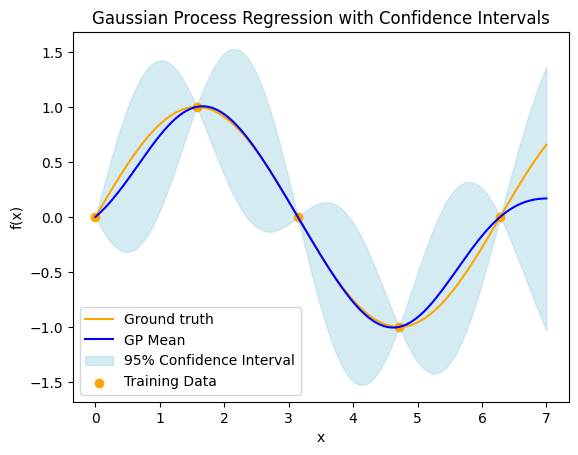

In [23]:
def plot_gp_with_confidence(x_train, y_train, x_test, mean_pred, var_pred, show=True, confidence=1.96):
    std_pred = np.sqrt(var_pred)  # Standard deviation is the square root of the variance

    # Plot the mean prediction
    plt.plot(x_test, y_true_vals, color='orange', label='Ground truth')
    plt.plot(x_test, mean_pred, color="blue", label="GP Mean")

    # Plot the confidence interval
    plt.fill_between(x_test, 
                     mean_pred - confidence * std_pred, 
                     mean_pred + confidence * std_pred, 
                     color="lightblue", alpha=0.5, label="95% Confidence Interval")
    
    # Plot the original data points
    plt.scatter(x_train, y_train, color="orange", label="Training Data")
    
    # Add labels and legend
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Gaussian Process Regression with Confidence Intervals")
    plt.legend()
    if show:
        plt.show()

plot_gp_with_confidence(x_train, y_train, x_test, meann, variancee)

 * Define the Acquisition Function UCB method for a single data point 
    * e.g. `def acq_ucb(x):`...  
Iteratively find the optimum of $f(x)$ by optimising the Acquisition Function at each iteration.  

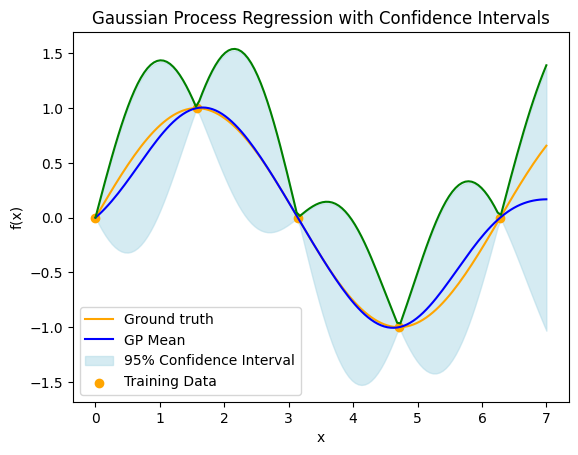

In [24]:
lambdaa = 2.0  # Exploration-exploitation parameter

# Modify UCB to accept a single test point
def upper_confidence_bound(x_single):
    # Compute the kernel between the new point and the training points
    K_test_train_single = rbf_kernel([x_single], x_train)  # Shape (1, N)
    K_test_test_single = rbf_kernel([x_single], [x_single])  # Shape (1, 1)
    
    # Calculate the mean for this specific point
    mean_single = mean(K_test_train_single, K_train_train, y_train)
    
    # Calculate the variance for this specific point
    variance_single = variance(K_test_test_single, K_test_train_single, K_train_train, K_test_train_single.T)
    
    # Ensure variance is not zero by adding a small epsilon (to avoid divide by zero)
    variance_single = np.diag(variance_single) + 1e-8  # Small epsilon added
    
    # Calculate UCB for the single point
    return mean_single + lambdaa * np.sqrt(variance_single)


# Adjust negative_ucb to optimize UCB at a single point
def negative_ucb(x_test_single):
    return -upper_confidence_bound(x_test_single)

plot_gp_with_confidence(x_train, y_train, x_test, meann, variancee, show=False)
ucb_vals = [upper_confidence_bound(el) for el in x_test]
plt.plot(x_test, ucb_vals, color="green", label=f"UCB lambda={lambdaa}")
plt.show()

In [25]:
def update_kernel_matrix(K_train_train, x_train, x_new, rbf_kernel):
    """
    Efficiently update the training kernel matrix with a new point.
    """
    # Compute kernel values between x_new and all current training points
    K_new_train = rbf_kernel(x_train, [x_new])
    
    # Append new row and column to K_train_train
    K_train_train = np.vstack([K_train_train, K_new_train.T])  # Append new row
    K_new_train_with_self = np.append(K_new_train, rbf_kernel([x_new], [x_new]))  # Append the diagonal element
    K_train_train = np.hstack([K_train_train, K_new_train_with_self.reshape(-1, 1)])  # Append new column
    
    return K_train_train

def update_test_kernel_matrix(K_test_train, x_test, x_new, rbf_kernel):
    """
    Efficiently update the test-training kernel matrix with a new point.
    """
    # Compute kernel values between x_new and all test points
    K_new_test = rbf_kernel(x_test, [x_new])
    
    # Append the new column to K_test_train
    K_test_train = np.hstack([K_test_train, K_new_test])
    
    return K_test_train


In [26]:
from scipy.optimize import minimize

# Assume the initial kernel matrices are already computed
K_train_train = rbf_kernel(x_train, x_train)
K_test_train = rbf_kernel(x_test, x_train)

n_iterations = 10  # Number of iterations
for i in range(n_iterations):
    # Step 1: Optimize the acquisition function (UCB) to find the next point
    res = minimize(negative_ucb, x0=np.random.uniform(minn, maxx), bounds=[(minn, maxx)])
    x_next = res.x
    
    # Step 2: Evaluate the true function at this new point
    y_next = sin(x_next)  # This is the true function, replace with your actual function
    
    # Step 3: Add the new point to the training data
    x_train = np.append(x_train, x_next)
    y_train = np.append(y_train, y_next)
    
    # Step 4: Efficiently update the kernel matrices
    K_train_train = update_kernel_matrix(K_train_train, x_train[:-1], x_next, rbf_kernel)
    K_test_train = update_test_kernel_matrix(K_test_train, x_test, x_next, rbf_kernel)
    
    # Step 5: Recompute the mean and variance using the updated kernel matrices
    meann = mean(K_test_train, K_train_train, y_train)
    variancee_mat = variance(K_test_test, K_test_train, K_train_train, np.transpose(K_test_train))
    variancee = np.diag(variancee_mat)
    
    # Step 6: Plot the updated GP and UCB
    plot_gp_with_confidence(x_train, y_train, x_test, meann, variancee, show=False)
    plt.plot(x_test, upper_confidence_bound(x_test), color="green", label=f"UCB lambda={lambdaa}")
    plt.legend()
    plt.show()

    print(f"Iteration {i+1}, x_next = {x_next}, f(x_next) = {y_next}")


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 5)